<h1><center> Correlation matrix for UPR Perturb Seq experiement  </h1></center>


# Warning
**This notebook is not relevant anymore:** The goal was to recreate the Figure 3F of [\[1\]](#references) to infer the chemical treatment of the UPR epistasis experiment in the Adamson dataset. It was all written from the very begining within the paper: 
> Note in the raw sequencing data the tunicamycin-treated cells have gemgroup 1 (as a BAM tag), the thapsigargin-treated cells have gemgroup 2, and the DMSO-treated cells have gemgroup 3.


This notebook aims to **recreate Figure 3F** from the following publication [\[1\]](#references):

---

## Goal

In the original data, **the metadata for chemical treatment is missing**: 
- tunicamycin 4 μg/mL  for 6hr, an N-linked glycosylation inhibitor.
- thapsigargin  100 nM 4 hr, an Endoplasmic Reticulum (ER) calcium pump inhibitor
- DMSO (control)

This is a problem because those treatment induce a ER stress. Hence it cannot be seen as a regular cell.
Looking at the cell barcode, they are always finishing with a hyphen which indicate the sequencing lane of the **10x 3' v1 platform**. In this notebook, it is assumed that each batch of treated cell where sequenced on different lane.

This Notebook will aim at recreating the Figure 3F of [\[1\]](#references) as subtle differences help differentiating the two chemical treatments.

After trying all combination we will use this convention and show that we can recreate the Figure 3F.

> - 1: tunicamycin 4 μg/mL  for 6hr
> - 2: thaspigargin  100 nM 4 hr
> - 3: DMSO

## Roadmap

The goal of this notebook is to process and analyze single-cell CRISPR perturbation data from the UPR (Unfolded Protein Response) Perturb-seq experiment, following the approach in Adamson et al. (2016) in the section: **"Branch epistasis analysis in Figure 3F"**. The full process is not replicated and is instead simplified (No classification is performed, and genes for the [heatmap]() are taken from theirs.)

1. Load and preprocess the raw data from the Adamson UPR Perturb-seq experiment.
2. Filter and normalize the data, and annotate gene symbols.
3. Z-Normalize according to presumed control -3.
4. Aggregate the data to pseudo-bulk profiles for each perturbation condition.
5. Generate a correlation matrix and heatmap for selected genes, matching the presentation in Figure 3F of the paper.
6. Further clustering Visualization.

---

## References
> [1] Adamson B et al. "Multiplexed Single-Cell CRISPR Screening Platform Enables Systematic Dissection of the UPR" Cell. 2016 [https://doi.org/10.1016/j.cell.2016.11.048](https://doi.org/10.1016/j.cell.2016.11.048)

## 1) Load Adata

In [1]:
# All imports here
from pathlib import Path

import anndata as ad
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import median_abs_deviation

data_path = Path("./../datasets")


%reload_ext autoreload
%autoreload 2


## 2) Filter out cells and Annotate

In [2]:
adamson_dir = data_path.joinpath("raw/raw_adamson")
prefix = "GSM2406677_10X005"

# Paths
barcodes_file = adamson_dir / f"{prefix}_barcodes.tsv.gz"
genes_file = adamson_dir / f"{prefix}_genes.tsv.gz"
identities_file = adamson_dir / f"{prefix}_cell_identities.csv.gz"
mtx_file = adamson_dir / f"{prefix}_matrix.mtx.txt.gz"

# Load metadata
genes = pd.read_csv(genes_file, header=None, sep="\t")
barcodes = pd.read_csv(barcodes_file, header=None)
cell_identities = pd.read_csv(identities_file, index_col=0)

# Create AnnData
adata_epistasis = ad.io.read_mtx(mtx_file).T
adata_epistasis.var_names = genes[0].values
adata_epistasis.obs_names = barcodes[0].values
adata_epistasis.obs = pd.DataFrame(index=adata_epistasis.obs_names)
adata_epistasis.obs = adata_epistasis.obs.join(cell_identities) # fill with NaN barcodes with non found identity

# Optional: keep track of the experiment
adata_epistasis.obs["experiment"] = prefix

Download the genome mapping if not yet done:

In [ ]:
%%bash
cd ../../ # cd to root of the project
python fine_tune/scripts/genome.py

In [3]:
# UPR epistasis experiment - keep only guide containing any of ctrl, IRE1, PERK, ATF6
adata_epistasis = adata_epistasis[
    adata_epistasis.obs["guide identity"].astype(str).str.contains("(ctrl|IRE1|PERK|ATF6)")
].copy()

# retrieve geme symbol
gene_name = pd.read_csv(
    data_path.joinpath("genome/gencode.v32.primary_assembly.annotation.csv"),
    index_col="ensembl_id"
)
adata_epistasis.var["gene_symbol"] = (
    gene_name
    .reindex(adata_epistasis.var_names)
    .fillna(adata_epistasis.var_names.to_frame(name="symbol"))
)

/tmp/ipykernel_1413782/694480831.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  adata_epistasis.obs["guide identity"].astype(str).str.contains("(ctrl|IRE1|PERK|ATF6)")


In [4]:
# rename ctrl in triple non targeting: NT+NT+NT
adata_epistasis.obs["gene_perturbed"] = adata_epistasis.obs["guide identity"].where(
        ~adata_epistasis.obs["guide identity"].str.contains("ctrl"), "NT+NT+NT"
    )

# remove guide id,
# change "IRE1" -> "ERN1" and "PERK" -> "EIF2AK3"
# make sure simple or double perturbation remains marked
# as +NT+NT or +NT because triple guide were used for that experiment
adata_epistasis.obs["gene_perturbed"] = adata_epistasis.obs["gene_perturbed"].str.split("_").apply(
    lambda row: row[0] if len(row) == 1 else (
        "+".join(
            [
                {"only": "NT", "IRE1": "ERN1", "PERK": "EIF2AK3"}.get(x, x)
                for x in row[:-1]
            ] + (["NT"] if len(row[:-1]) < 3 else [])
        )
    )
)

In [5]:
# Filter low quality cell

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_epistasis.var["mt"] = adata_epistasis.var["gene_symbol"].str.startswith("MT-")
# ribosomal genes
adata_epistasis.var["ribo"] = adata_epistasis.var["gene_symbol"].str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_epistasis.var["hb"] = adata_epistasis.var["gene_symbol"].str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata_epistasis, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)


def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adata_epistasis.obs["outlier"] = (
    is_outlier(adata_epistasis, "log1p_total_counts", 5) |
    is_outlier(adata_epistasis, "log1p_n_genes_by_counts", 5) |
    is_outlier(adata_epistasis, "pct_counts_in_top_20_genes", 5)
)
adata_epistasis.obs["mt_outlier"] = is_outlier(adata_epistasis, "pct_counts_mt", 3) | (
    adata_epistasis.obs["pct_counts_mt"] > 8
)

print(f"Total number of cells: {adata_epistasis.n_obs}")
adata_epistasis = adata_epistasis[(~adata_epistasis.obs.outlier) & (~adata_epistasis.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata_epistasis.n_obs}")

Total number of cells: 14776
Number of cells after filtering of low quality cells: 13039


## 3) Z-normalize according to presumed control

Z-normalize based on ctrl + DMSO which is assumed to be NT+NT+NT-3
-1, -2, -3 refer to the batch of sequencing. Each batch is assumed to correspond
to a different solvent.

In [6]:
adata_epistasis.obs["batch"] = adata_epistasis.obs_names.to_series().str.split("-").apply(lambda x: x[1])
adata_epistasis.obs["condition"] = (
    adata_epistasis.obs["gene_perturbed"].astype(str) + "-" + adata_epistasis.obs["batch"]
)

adata_epistasis.layers["count"] = adata_epistasis.X
sc.pp.normalize_total(adata_epistasis)
adata_epistasis.layers["normalized"] = adata_epistasis.X

ctrl_mask = adata_epistasis.obs["condition"].str.contains("NT+NT+NT-3", regex=False)
ctrl_mean = adata_epistasis[ctrl_mask].X.toarray().mean(axis=0)
ctrl_std = adata_epistasis[ctrl_mask].X.toarray().std(axis=0)
ctrl_std = np.where(ctrl_std == 0, 1, ctrl_std)

adata_epistasis.X = (adata_epistasis.X - ctrl_mean) / ctrl_std
adata_epistasis.layers["z_norm_ctrl"] = adata_epistasis.X

/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


## 4) Separate cells into groups and create pseudo-bulk profiles

1. Retrieve correct gene names
2. Create Pseudo-bulk profile
3. Create a table that store whether a gene is perturbed or not: 
    - It is a 3 column table [PERK, ATF6, IRE1]
    - If DMSO (NT+NT+NT-3), then 0.5 in all columns
    - For every other perturbation, if one of the gene is perturbed then it will be a white pixel: 1, otherwise it is black 0

In [7]:
# selected_genes from the Figure 3F
selected_genes = [
"YIF1A","TMEM165","SLC25A3","CD59","HBG2","HBG1","HSPA8","HSPA1A","HSPE1","RPS26","PPIA","PRDX1","NDUFS5","DNAJA1",
"DYNLL1","FAU","PTMA","CALM2","TUBB4B","TUBB","UQCR11","COX6B1","POLR2L","COX6A1","RPS10","DDIT3","TRIB3","DDIT4",
"SNHG8","ZFAS1","C6orf48","PSPH","XBP1","CTH","MTHFD2","EIF4EBP1","EIF1","CEBPG","SOCS2","SESN2","CEBPB","YDJC",
"OXLD1","CCPG1","BEX2","IDH1","LMO4","MAP3K8","HAX1","HOXB9","FAM89A","ST6GALNAC1","PCK2","GARS1","MAP1B","RGS16",
"TSC22D3","WARS1","PHGDH","PSAT1","ATF4","PIM1","SLC3A2","EIF1B","PPP1R15A","CCNB1IP1","BTG1","EPB41L4A-AS1",
"HERPUD1","HSPA5","SDF2L1","DNAJB11","MANF","HSP90B1","DNAJC3","SELK","CDK2AP2","CRELD2","PDIA6","PDIA4","CALR",
"TMEM50B","HYOU1","RSBN1L","DERL2","SLC35B1","DNAJB9","TMED2","SERP1","VIMP","ERLEC1","ARMCX3","TIMM17A",
"SEC61A1","SEC61B","PPIB","TMED9","C19orf10","SSR2","NANS","OSTC","SSR3","SSR1","MTDH"
]
renamed_gene = {"C6orf48": "SNHG32", "SELK": "SELENOK", "VIMP": "SELENOS", "C19orf10": "MYDGF"}
selected_genes = [renamed_gene.get(g, g) for g in selected_genes]
selected_genes_ens_id = adata_epistasis.var["gene_symbol"].reset_index().set_index(
    "gene_symbol"
).loc[selected_genes]["index"].values

In [8]:
# Subset to selected genes and expression layer
X = adata_epistasis[:, selected_genes_ens_id].layers["z_norm_ctrl"]#.toarray()

# Create a DataFrame with target labels
targets = adata_epistasis.obs["condition"].values

# Create a DataFrame of expression (cells x genes)
expr_df = pd.DataFrame(X, columns=adata_epistasis[:, selected_genes_ens_id].var["gene_symbol"])

# Add target as a column
expr_df["target"] = targets

# Group by target and average (mean = pseudo-bulk)
pseudobulk_expr_epistasis = expr_df.groupby("target").mean()

# Optional: reindex if you want targets in a specific order
pseudobulk_expr_epistasis = pseudobulk_expr_epistasis.sort_index()
adata_pseudobulk_epistasis = ad.AnnData(
    X=pseudobulk_expr_epistasis.values,
    obs=pd.DataFrame(index=pseudobulk_expr_epistasis.index),       # target groups as observations
    var=pd.DataFrame(index=pseudobulk_expr_epistasis.columns) # genes as variables
)



In [9]:
# --- Rename genes ---
rename_dict = {"EIF2AK3": "PERK", "ERN1": "IRE1"}
gene_symbols = [rename_dict.get(g, g) for g in adata_epistasis[:, selected_genes_ens_id].var["gene_symbol"].tolist()]

# --- Define row orders ---
row_order_1 = [
    "NT+NT+NT-3",
    "ATF6+EIF2AK3+ERN1-1",
    "ATF6+EIF2AK3+NT-1",
    "EIF2AK3+ERN1+NT-1",
    "EIF2AK3+NT+NT-1",
    "ATF6+ERN1+NT-1",
    "ATF6+NT+NT-1",
    "ERN1+NT+NT-1",
    "NT+NT+NT-1"
]
row_order_2 = [
    "NT+NT+NT-3",
    "ATF6+EIF2AK3+ERN1-2",
    "ATF6+EIF2AK3+NT-2",
    "EIF2AK3+ERN1+NT-2",
    "EIF2AK3+NT+NT-2",
    "ATF6+ERN1+NT-2",
    "ATF6+NT+NT-2",
    "ERN1+NT+NT-2",
    "NT+NT+NT-2"
]

df_group1 = pseudobulk_expr_epistasis.loc[row_order_1, gene_symbols]
df_group2 = pseudobulk_expr_epistasis.loc[row_order_2, gene_symbols]
df_group1.index = df_group1.index.str.replace(*list(rename_dict.items())[0]).str.replace(*list(rename_dict.items())[1])
df_group2.index = df_group2.index.str.replace(*list(rename_dict.items())[0]).str.replace(*list(rename_dict.items())[1])

# --- Presence grid builder ---
def build_presence_matrix(rows, label):
    data = []
    for row in rows:
        if "NT+NT+NT-3" in row:
            data.append([0.5, 0.5, 0.5])  # Gray for control
        else:
            data.append([
                1.0 if "PERK" in row else 0.0,
                1.0 if "ATF6" in row else 0.0,
                1.0 if "IRE1" in row else 0.0
            ])
    return pd.DataFrame(data, index=rows, columns=["PERK", "ATF6", "IRE1"])

presence_group1 = build_presence_matrix(df_group1.index, "-1")
presence_group2 = build_presence_matrix(df_group2.index, "-2")

## 5) Figure 3F

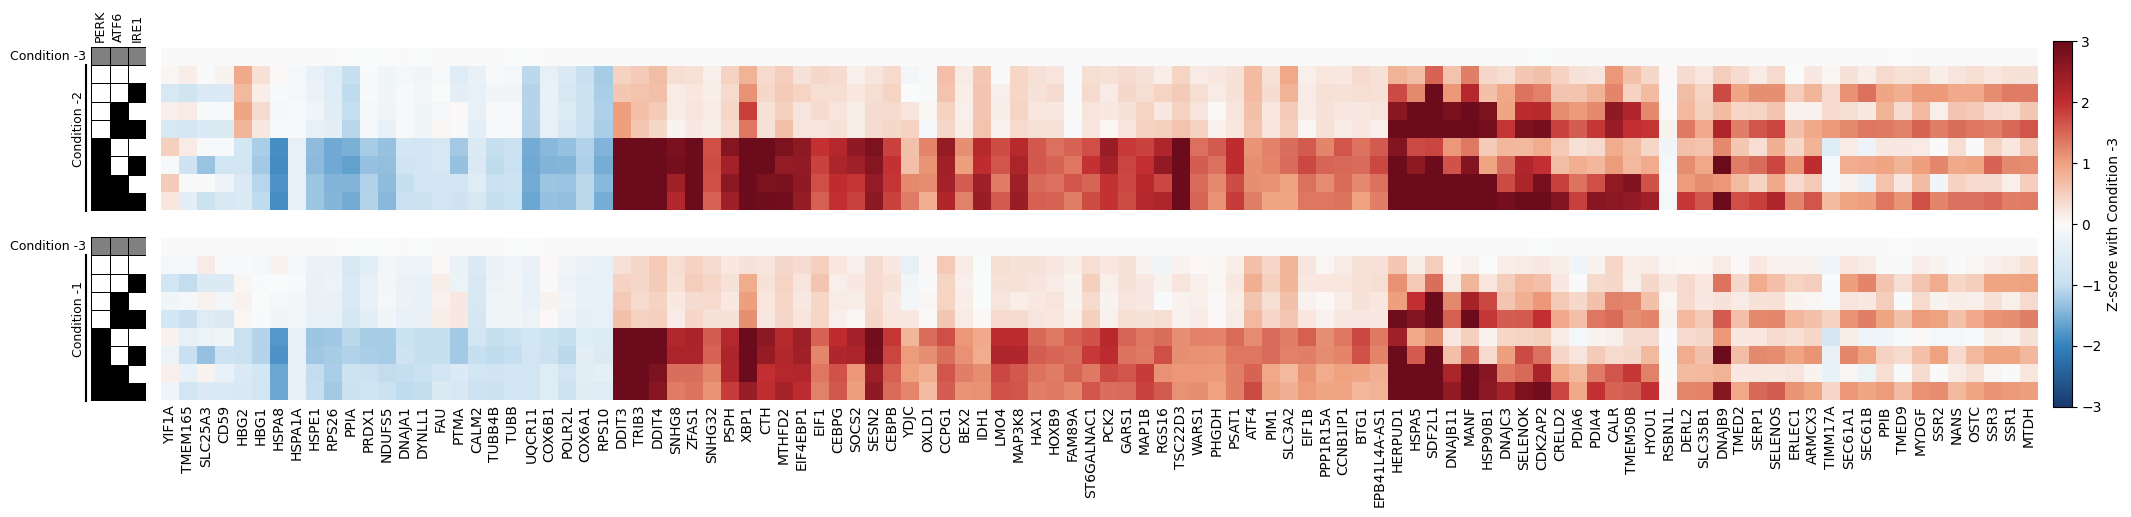

In [10]:
# --- Plotting ---
x_size, y_size = (
    sum((width_ratios := [len(presence_group1.columns), len(df_group1.columns) - 1 , 1 ])) * 0.2,
    len(presence_group1.index) * 0.3 * 2 - 0.5
)
fig = plt.figure(figsize=(x_size, y_size))
gs = gridspec.GridSpec(2, 3, width_ratios=width_ratios, height_ratios=[1, 1], figure=fig)


# Define RGB as normalized [0,1] values
colors = [
    (25/255, 57/255, 110/255),   # Dark blue
    (51/255, 131/255, 190/255),  # Mid blue
    (198/255, 223/255, 240/255), # Light blue
    (250/255, 250/255, 250/255), # Near white
    (239/255, 162/255, 127/255), # Peachy
    (193/255, 45/255, 48/255),   # Vivid red
    (107/255, 11/255, 27/255)    # Deep red
]


# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("blue_white_red", colors)

# Plot presence matrix group 2
ax0_top = fig.add_subplot(gs[0, 0])
sns.heatmap(presence_group2, ax=ax0_top, cmap=["black", "gray", "white"], cbar=False,
            xticklabels=True, yticklabels=True, linewidths=0.5, linecolor='black')
ax0_top.set_xticklabels(presence_group2.columns, rotation=90, fontdict={"fontsize": 9})
ax0_top.tick_params(axis=u'both', which=u'both',length=0)
ax0_top.xaxis.tick_top()
ax0_top.axes.get_yaxis().set_visible(False)
ax0_top.set_aspect('equal', adjustable='box')

# Plot presence matrix group 1
ax0_bottom = fig.add_subplot(gs[1, 0])
sns.heatmap(presence_group1, ax=ax0_bottom, cmap=["black", "gray", "white"], cbar=False,
            xticklabels=True, yticklabels=True, linewidths=0.5, linecolor='black')
ax0_bottom.set_xticklabels(presence_group1.columns, rotation=90)
ax0_bottom.tick_params(axis=u'both', which=u'both',length=0)
ax0_bottom.xaxis.tick_top()
ax0_bottom.set_axis_off()
ax0_bottom.set_aspect('equal', adjustable='box')

for ax, row_order, cond_label in zip(
    [ax0_top, ax0_bottom],
    [row_order_2, row_order_1],
    ["Condition -2", "Condition -1"]
):
    # Index of the control row
    control_row = row_order.index("NT+NT+NT-3")
    line_x = -0.3  # Slightly to the left of heatmap
    # Add vertical label (spanning all rows except control)
    n_rows = len(row_order)
    if control_row > 0:
        # Text above control
        ax.text(
            -0.7, (control_row) / 2 +2, cond_label, va='center', ha='center',
            fontsize=9, rotation=90, transform=ax.transData
        )
        ax.plot(
            [line_x, line_x],
            [0, control_row],
            color='black', linewidth=1.5,
            transform=ax.transData, clip_on=False
        )
    if control_row < n_rows - 1:
        # Text below control
        ax.text(
            -0.7, (control_row + 1 + n_rows) / 2 / 2 +2, cond_label, va='center', ha='center',
            fontsize=9, rotation=90, transform=ax.transData
        )
        ax.plot(
            [line_x, line_x],
            [control_row + 1, n_rows],
            color='black', linewidth=1.5,
            transform=ax.transData, clip_on=False
        )

    # Add horizontal label for the control row
    ax.text(
        -0.3, control_row + 0.5, "Condition -3", va='center', ha='right',
        fontsize=9, rotation=0, transform=ax.transData
    )



# Plot heatmap group 2
ax2 = fig.add_subplot(gs[0, 1], sharey=ax0_top)
sns.heatmap(df_group2, ax=ax2, cmap=custom_cmap, vmin=-3, vmax=3,
            cbar=False, xticklabels=False, yticklabels=False)
ax2.set_axis_off()
ax2.set_aspect('equal', adjustable='box')

# Plot heatmap group 1
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2, sharey=ax0_bottom)
sns.heatmap(df_group1, ax=ax3, cmap=custom_cmap, vmin=-3, vmax=3,
            cbar=False, xticklabels=True, yticklabels=False)
ax3.tick_params(axis='x', rotation=90)
ax3.tick_params(axis=u'both', which=u'both',length=0)
ax3.set_ylabel("")
ax3.set_xlabel("")
ax3.set_aspect('equal', adjustable='box')

# Shared colorbar
cax = fig.add_subplot(gs[:, 2])
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=-3, vmax=3))
fig.colorbar(sm, cax=cax, label="Z-score with Condition -3")


plt.tight_layout()
plt.show()


Looking at the figure obtained and the on in Figure 3F [\[1\]](#references), we can deduct, assuming that the subscipt -1, -2, -3 refers to different line of the 10x 3' v1 and that for each condition a new line has been used that: 
- 1: tunicamycin 4 μg/mL  for 6hr
- 2: thapsigargin  100 nM 4 hr
- 3: DMSO

## 6) Additional Clustering

In [11]:
sc.pp.pca(adata_epistasis)
sc.pp.neighbors(adata_epistasis)
sc.tl.umap(adata_epistasis)

In [12]:
sc.tl.leiden(
        adata_epistasis, key_added=f"leiden_res_{0.5:4.2f}", resolution=0.5, flavor="igraph"
)

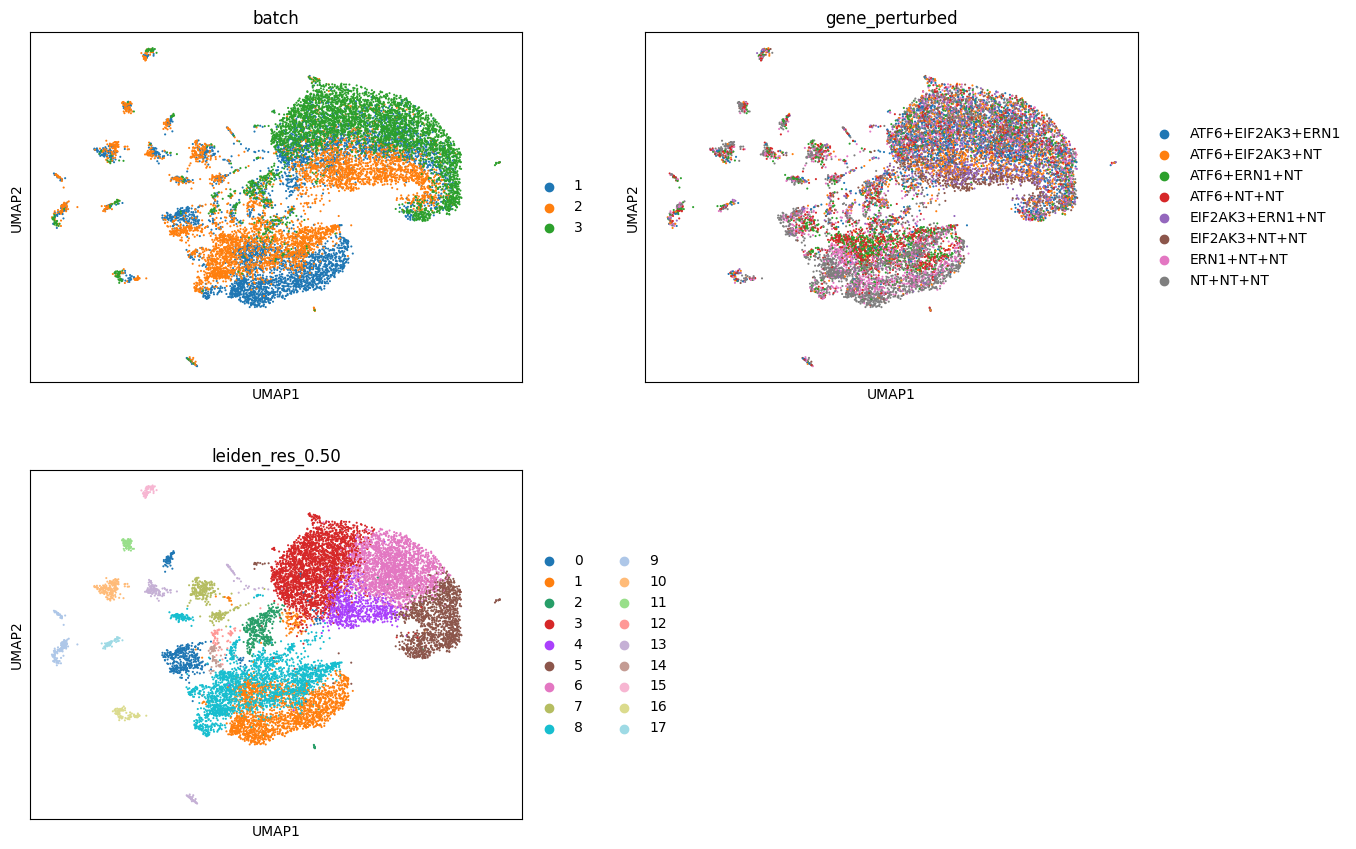

In [13]:
sc.pl.umap(
    adata_epistasis,
    color=['batch', 'gene_perturbed', "leiden_res_0.50"],
    ncols=2
)

In [14]:
adata_epistasis.var = adata_epistasis.var.reset_index().rename(columns={"index": "ensembl_id"}).set_index("gene_symbol")

In [15]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata_epistasis, groupby="leiden_res_0.50", method="wilcoxon")

/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/hhakem/projects/cellarium-ml/.venv/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value enco

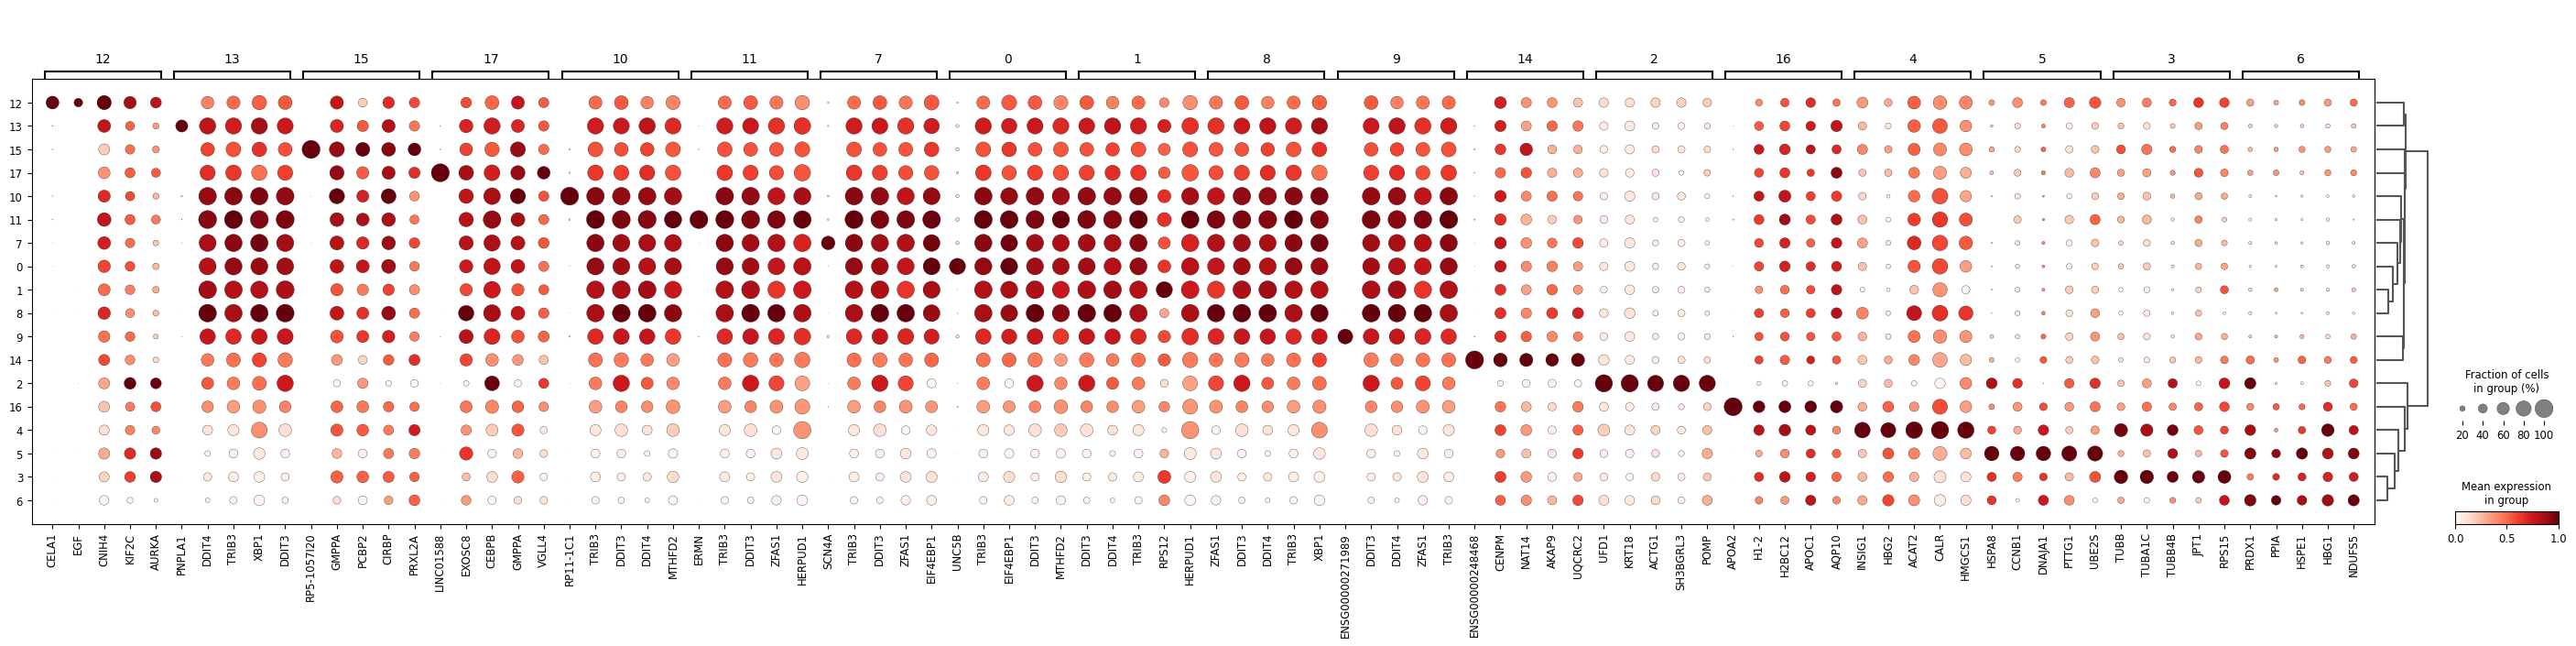

In [16]:
sc.pl.rank_genes_groups_dotplot(
    adata_epistasis, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

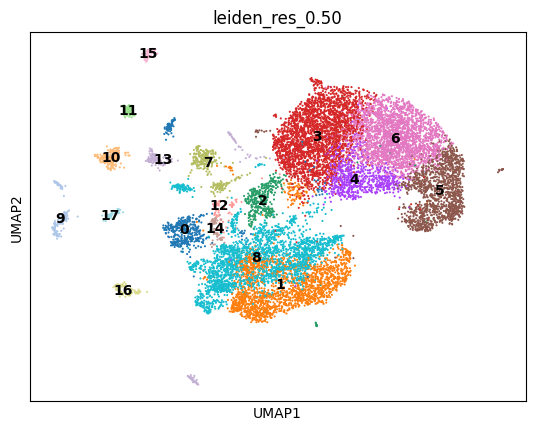

In [17]:
sc.pl.umap(
    adata_epistasis,
    color="leiden_res_0.50",
    legend_loc="on data",
)